In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install sqlite3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [2]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 38.0293,
	"longitude": -78.4767,
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "showers", "snowfall", "snow_depth", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
	"timezone": "auto",
	"past_days": 7,
	"wind_speed_unit": "mph",
	"temperature_unit": "fahrenheit",
	"precipitation_unit": "inch"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_showers = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(7).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(8).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(9).ValuesAsNumpy()

hourly_data = {"time": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["showers"] = hourly_showers
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

api_data = pd.DataFrame(data = hourly_data)
print(api_data)

Coordinates 38.03147888183594°N -78.46525573730469°E
Elevation 151.0 m asl
Timezone b'America/New_York'b'GMT-4'
Timezone difference to GMT+0 -14400 s
                         time  temperature_2m  relative_humidity_2m  \
0   2025-03-17 04:00:00+00:00       58.864101                  87.0   
1   2025-03-17 05:00:00+00:00       57.964104                  85.0   
2   2025-03-17 06:00:00+00:00       58.504097                  84.0   
3   2025-03-17 07:00:00+00:00       57.154099                  83.0   
4   2025-03-17 08:00:00+00:00       56.524101                  66.0   
..                        ...             ...                   ...   
331 2025-03-30 23:00:00+00:00       68.429298                  75.0   
332 2025-03-31 00:00:00+00:00       65.909302                  81.0   
333 2025-03-31 01:00:00+00:00       64.199303                  87.0   
334 2025-03-31 02:00:00+00:00       62.759300                  93.0   
335 2025-03-31 03:00:00+00:00       61.769299                  97.0  

In [6]:
import re
import sqlite3

# Function to generate summary of dataset
def summarize_data(dataframe, data_type="raw"):
    num_records = len(dataframe)
    num_columns = len(dataframe.columns)
    print(f"\n{data_type} Data Summary:")
    print(f" - Number of Records: {num_records}")
    print(f" - Number of Columns: {num_columns}")

# Function to read in csv or json file
def read_data(file_path):
  if file_path.endswith('.csv'):
    return pd.read_csv(file_path, skiprows=3)
  elif file_path.endswith('.json'):
    return pd.read_json(file_path)
  else:
    raise ValueError("Unsupported file format. Please provide a .csv or .json file.")

# Clean units out of column names to have identical names
def clean_column(col):
  return re.sub(r'\s*\([^)]*\)', '', col).strip().lower()

# Allow user to input csv or json for static file
file_path = input("Enter the path to the static data file (CSV or JSON): ").strip()
static_data = read_data(file_path)

static_data.columns = [clean_column(col) for col in static_data.columns]
api_data.columns = [clean_column(col) for col in api_data.columns]

# Convert time from dataset to datetime format
static_data['time'] = pd.to_datetime(static_data['time'])
api_data['time'] = pd.to_datetime(api_data['time']).dt.tz_localize(None)

# Summarize data before merge
summarize_data(static_data, "Raw Static")
summarize_data(api_data, "Raw API")

# Merge the api dataset to the csv dataset using same columns
combined_data = pd.concat([static_data, api_data], ignore_index=True)

# Summarize merged data
summarize_data(combined_data, "Transformed")

# Save data as a SQL database via sqlite
conn = sqlite3.connect('combined_weather_data.db')
combined_data.to_sql('combined_weather_data', conn, if_exists='replace', index=False)

Enter the path to the static data file (CSV or JSON): weather_data.json

Raw Static Data Summary:
 - Number of Records: 43848
 - Number of Columns: 11

Raw API Data Summary:
 - Number of Records: 336
 - Number of Columns: 11

Transformed Data Summary:
 - Number of Records: 44184
 - Number of Columns: 11


44184

In [4]:
# Function to add new column to dataset
def add_column_to_sqlite(conn, table_name, column_name, column_type="TEXT"):
  cursor = conn.cursor()
  try:
    cursor.execute(f"ALTER TABLE {table_name} ADD COLUMN {column_name} {column_type};")
    conn.commit()
    print(f"Added column '{column_name}' to the database.")
  except sqlite3.DatabaseError as e:
    print(f"Error adding column: {e}")

# Function to remove specified column from dataset
def remove_column_from_sqlite(conn, table_name, column_name):
  cursor = conn.cursor()
  try:
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    columns = [col[1] for col in columns]

    if column_name not in columns:
      print(f"Column '{column_name}' does not exist in the database.")
      return

    columns.remove(column_name)
    columns_str = ", ".join(columns)
    cursor.execute(f"CREATE TABLE {table_name}_new AS SELECT {columns_str} FROM {table_name}")

    cursor.execute(f"DROP TABLE {table_name}")
    cursor.execute(f"ALTER TABLE {table_name}_new RENAME TO {table_name}")

    conn.commit()
    print(f"Removed column '{column_name}' from the database.")
  except sqlite3.DatabaseError as e:
    print(f"Error removing column: {e}")


def add_column(df, column_name, default_value, conn, table_name):
  df[column_name] = default_value
  print(f"Added column: {column_name}")
  add_column_to_sqlite(conn, table_name, column_name)
  return df

def remove_column(df, column_name, conn, table_name):
  if column_name in df.columns:
    df.drop(column_name, axis=1, inplace=True)
    print(f"Removed column: {column_name}")
    remove_column_from_sqlite(conn, table_name, column_name)
  else:
    print(f"Column '{column_name}' not found in dataframe.")
  return df

# Connect to the sqlite db
conn = sqlite3.connect('combined_weather_data.db')
table_name = 'combined_weather_data'

# Allow user to add or remove columns from dataset
modify_choice = input("\nWould you like to add or remove a column? (Add/Remove/None): ").strip().lower()

if modify_choice == "add":
  column_name = input("Enter the name of the column to add: ")
  default_value = input("Enter the default value for the new column: ")
  combined_data = add_column(combined_data, column_name, default_value, conn, table_name)
elif modify_choice == "remove":
  column_name = input("Enter the name of the column to remove: ")
  combined_data = remove_column(combined_data, column_name, conn, table_name)
elif modify_choice != "none":
  print("Invalid choice")

# Allow user to choose which file format for the data
choice = input("\nWhat format of data would you like (JSON, CSV, SQL)?: ").strip().upper()
if choice == "JSON":
  combined_data.to_json('combined_weather_data.json', orient='records', lines=True)
elif choice == "CSV":
  combined_data.to_csv('combined_weather_data.csv')
elif choice == "SQL":
  conn = sqlite3.connect('combined_weather_data.db')
  combined_data.to_sql('combined_weather_data', conn, if_exists='replace', index=False)
else:
  print("Invalid choice")


Would you like to add or remove a column? (Add/Remove/None): none

What format of data would you like (JSON, CSV, SQL)?: sql


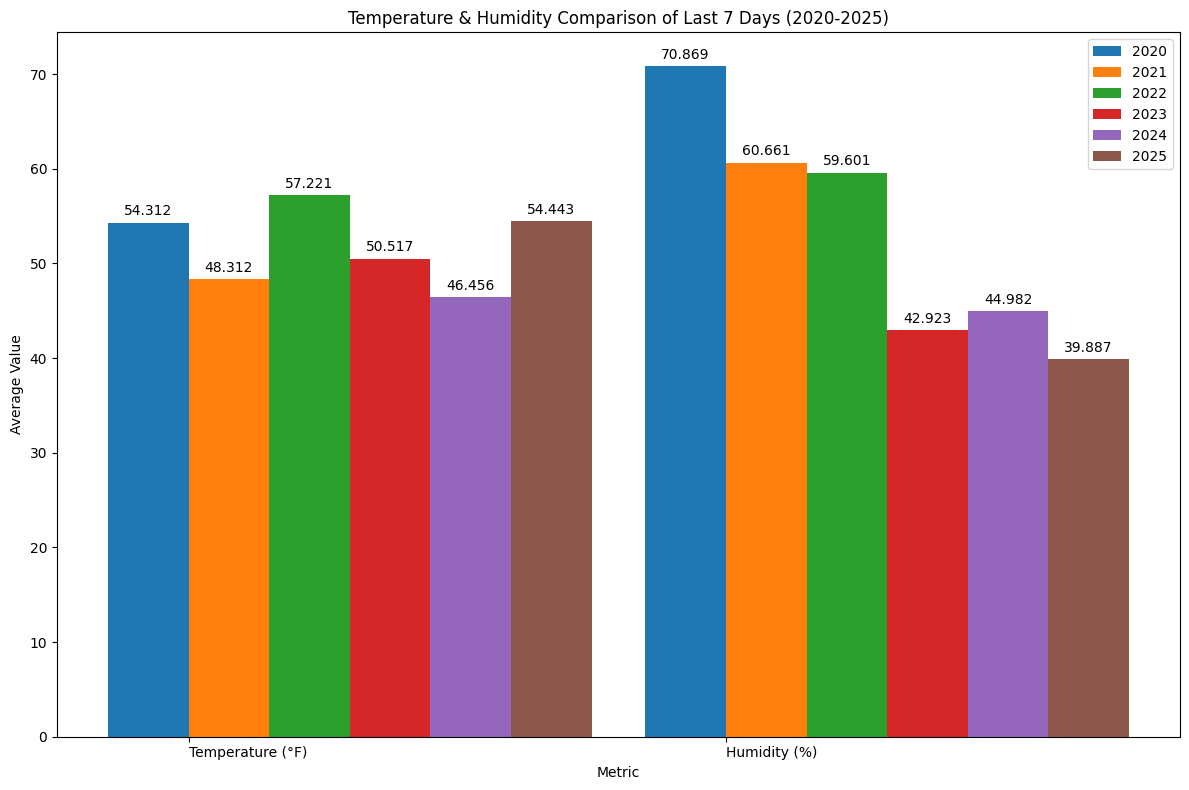

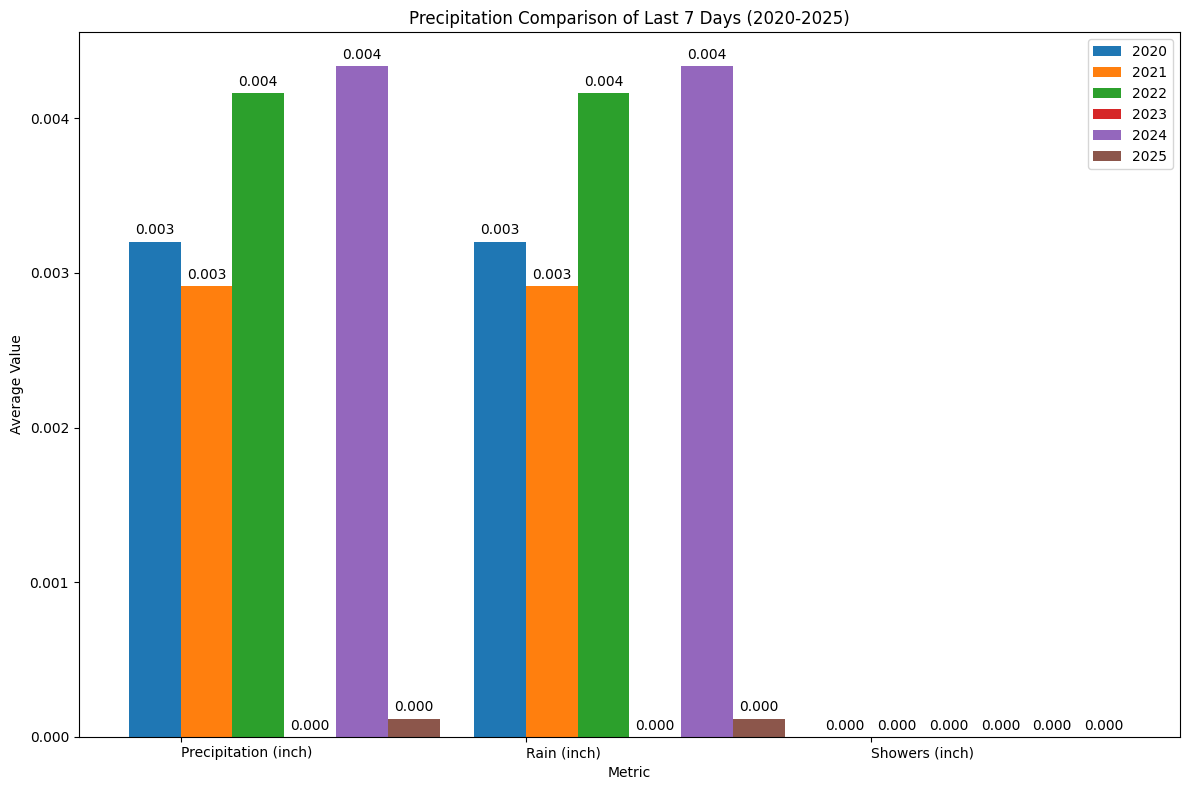

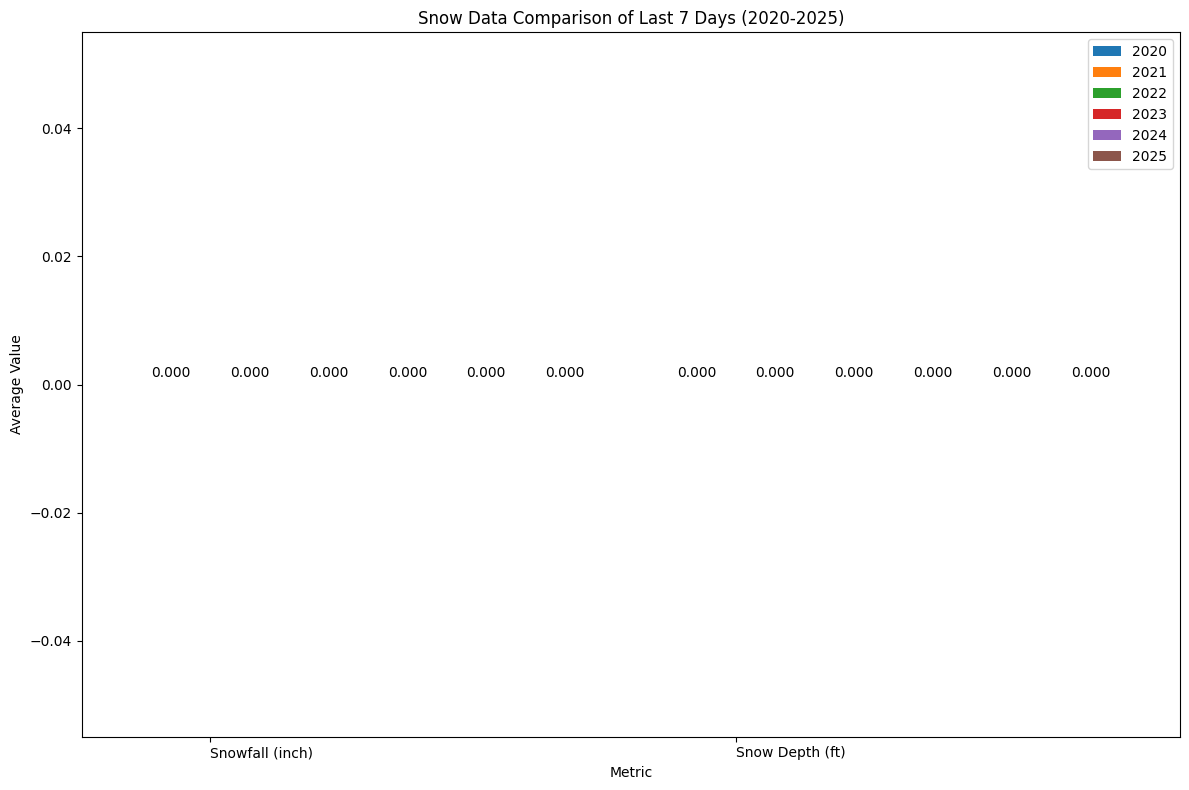

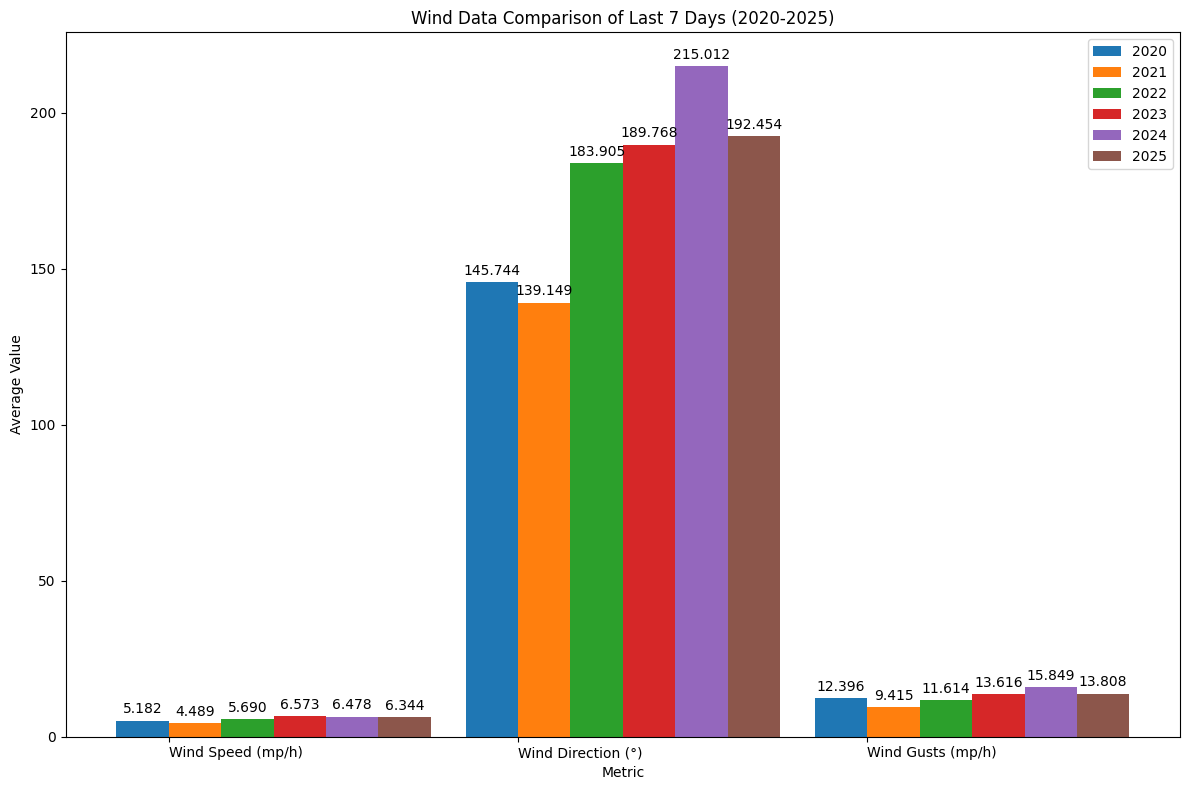

In [7]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

# Connect to sqlite db and get all data
conn = sqlite3.connect('combined_weather_data.db')
df = pd.read_sql_query("SELECT * FROM combined_weather_data", conn)
df['time'] = pd.to_datetime(df['time'])

# Calculate last 7 day period this year and for previous years
current_date = datetime.now()
last_7_days = current_date - timedelta(days=7)
years = range(2020, 2025+1)

# Gather data for each year
avg_data = {}
for year in years:
    period_start = last_7_days.replace(year=year)
    period_end = current_date.replace(year=year)
    data = df[(df['time'] >= period_start) & (df['time'] <= period_end)]

    avg_data[year] = {
        'temperature_2m': data['temperature_2m'].mean(),
        'relative_humidity_2m': data['relative_humidity_2m'].mean(),
        'precipitation': data['precipitation'].mean(),
        'wind_speed_10m': data['wind_speed_10m'].mean(),
        'rain': data['rain'].mean(),
        'showers': data['showers'].mean(),
        'snowfall': data['snowfall'].mean(),
        'snow_depth': data['snow_depth'].mean(),
        'wind_direction_10m': data['wind_direction_10m'].mean(),
        'wind_gusts_10m': data['wind_gusts_10m'].mean()
    }

# Group categories for clearer comparison
groups = {
    'Temperature & Humidity': ['temperature_2m', 'relative_humidity_2m'],
    'Precipitation': ['precipitation', 'rain', 'showers'],
    'Snow Data': ['snowfall', 'snow_depth'],
    'Wind Data': ['wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m']
}
categories = {
    'Temperature & Humidity': ['Temperature (°F)', 'Humidity (%)'],
    'Precipitation': ['Precipitation (inch)', 'Rain (inch)', 'Showers (inch)'],
    'Snow Data': ['Snowfall (inch)', 'Snow Depth (ft)'],
    'Wind Data': ['Wind Speed (mp/h)', 'Wind Direction (°)', 'Wind Gusts (mp/h)']
}

# Plot each group
for group, metrics in groups.items():
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(metrics))

    for i, year in enumerate(years):
        values = [avg_data[year][metric] for metric in metrics]
        bars = plt.bar(index + i * bar_width, values, bar_width, label=str(year))
        plt.bar_label(bars, fmt='%.3f', padding=3)

    plt.xlabel('Metric')
    plt.ylabel('Average Value')
    plt.title(f'{group} Comparison of Last 7 Days (2020-2025)')
    ax.set_xticks([i + bar_width * (len(years) / 2) / len(years) for i in index])
    ax.set_xticklabels(categories[group], ha="left")
    plt.legend()
    plt.tight_layout()
    plt.show()

conn.close()